In [28]:
from model.transformers import Encoder
import torch
import numpy as np
len_traj = 40
batch_size = 4
d_obj = 2
d_embed = 256 # embedding dimension
n_heads = 1
d_k = 4
d_hidden = 64
d_class = 4
n_layers = 6 # Encoder内含
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
encoder = Encoder(d_obj, d_embed, d_class, d_k, d_hidden, n_heads, n_layers)
x = torch.randn(30, 4, 2)
y, _ = encoder(x)
def mapping_qpsk (
    data
):
    _real = np.real(data)
    _imag = np.imag(data)

    if _real > 0 and _imag > 0:
        return 0
    if _real > 0 and _imag < 0:
        return 1
    if _real < 0 and _imag > 0:
        return 2
    else:
        return 3
    
def cross_entropy(y_true,y_pred):
    C=0
    # one-hot encoding
    for col in range(y_true.shape[-1]):
        y_pred[col] = y_pred[col] if y_pred[col] < 1 else 0.99999
        y_pred[col] = y_pred[col] if y_pred[col] > 0 else 0.00001
        C+=y_true[col]*torch.log(y_pred[col])+(1-y_true[col])*torch.log(1-y_pred[col])
    return -C

In [29]:
from rezero.transformer import RZTXEncoderLayer
import torch.nn as nn
class Channel_param(nn.Module):
    def __init__(self):
        super(Channel_param, self).__init__()
        self.mapping = nn.LSTM(
            input_size = 1,
            hidden_size = 1, 
            num_layers = 3,
            batch_first = True
        )
        self.activation = nn.Tanh()
        self.fc = nn.Linear(8, 6)
    def forward(self, x):
        x = self.activation(x)
        x, (h, c) = self.mapping(x)
        x = self.activation(x)
        x = self.fc(x.squeeze())
        return x

class Stransformers(nn.Module):
    def __init__(self, d_obj, nhead, num_layer = 6, d_embed = 128, d_class = 4):
        super(Stransformers, self).__init__()
        self.embedding = nn.Linear(d_obj, d_embed)
        self.denoise = nn.Linear(d_embed, 256)
        self.denoise2 = nn.Linear(256, d_embed)
        enc_layer = RZTXEncoderLayer(d_embed, nhead)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layer)
        self.fc = nn.Linear(d_embed, d_class)

    def forward(self, x):
        y = self.embedding(x)
        y = nn.ReLU()(y)
        y = self.denoise(y)
        y = nn.ReLU()(y)
        y = self.denoise2(y)
        y = nn.ReLU()(y)
        y = self.encoder(y)
        y = nn.ReLU()(y)
        y = self.fc(y[-1, :, :])
        out = torch.log_softmax(y, dim = -1)
        return out

In [45]:
import torch
import numpy as np
from data_processing import *
import scipy.io as spio
from torch.nn import functional as F


Nr = 8
carrier_num = 1
symbol_num = 10000
channel_num = 5

_channel = {}
_tau = list()
_attenuation = list()
_fdoppler = list()
_Txsteering = list()
_Rxsteering = list()
_x = list()
_y = list()
_y_norm = list()
_y_norm_n = list()
_y_n =list()
h = list()

for i in range(1, channel_num+1):
    path = f'./SIMO_data/10dBTrial/ISAC_QPSK_OFDM_{i}.mat'
    print(path)
    data = spio.loadmat(path)
    # _tau.append(
    #     data['ISAC_data']['channel'][0][0]['time_delay'][0][0][0]
    # )
    # _fdoppler.append(
    #     data['ISAC_data']['channel'][0][0]['f_doppler'][0][0][0]
    # )
    # _Txsteering.append(
    #     data['ISAC_data']['channel'][0][0]['Tx_steeringangle'][0][0][0]
    # )
    # _Rxsteering.append(
    #     data['ISAC_data']['channel'][0][0]['Rx_steeringangle'][0][0][0]
    # )
    # _attenuation.append(
    #     data['ISAC_data']['channel'][0][0]['attenuation'][0][0][0]
    # )
    _x.append(
        data['ISAC_data']['x'][0][0]
    )
    _y.append(
        data['ISAC_data']['y'][0][0]
    )
    _y_norm.append(
        data['ISAC_data']['y_norm'][0][0]
    )
    _y_n.append(
        data['ISAC_data']['y_n'][0][0]
    )
    _y_norm_n.append(
        data['ISAC_data']['y_norm_n'][0][0]
    )
    h.append(
        data['ISAC_data']['h'][0][0]
    )

# _channel['time_delay'] = _tau
# _channel['doppler_shift'] = _fdoppler
# _channel['_Txsteering'] = _Txsteering
# _channel['_Rxsteering'] = _Rxsteering

x_simo, _y, y_simo, h = np.array(_x), np.array(_y), np.array(_y_norm), np.array(h)
y_simo_n = np.array(_y_norm_n)
_y_n = np.array(_y_n)

y_simo_isac = np.zeros(shape = (carrier_num, channel_num, symbol_num, Nr, 2))
y_simo_isac_org =  np.zeros(shape = (carrier_num, channel_num, symbol_num, Nr, 2))
label_simo_isac = np.zeros(shape = (carrier_num, channel_num, symbol_num))
for n in range (carrier_num):
    for i in range (channel_num):
        for j in range (symbol_num):
            label_simo_isac[n, i, j] = mapping_qpsk (
                x_simo[i, j, n]
            )
            for k in range (Nr):
                y_simo_isac[n, i, j, k] = np.array(
                    [
                        np.real(_y_n[i, j, n, k]),
                        np.imag(_y_n[i, j, n, k]),
                    ]
                )

                y_simo_isac_org[n, i, j, k] = np.array([
                    np.real(_y[i, j, n, k]),
                    np.imag(_y[i, j, n, k])
                ])



./SIMO_data/10dBTrial/ISAC_QPSK_OFDM_1.mat
./SIMO_data/10dBTrial/ISAC_QPSK_OFDM_2.mat
./SIMO_data/10dBTrial/ISAC_QPSK_OFDM_3.mat
./SIMO_data/10dBTrial/ISAC_QPSK_OFDM_4.mat
./SIMO_data/10dBTrial/ISAC_QPSK_OFDM_5.mat


In [46]:
import torch
from torch import nn

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(
            input_size, hidden_size, bidirectional=True, num_layers = 3
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes) # times 2 because of bidirection

    def forward(self, x):
        seq_len, batch_size, _ = x.size()
        h0 = torch.zeros(2*self.lstm.num_layers, batch_size, self.hidden_size).to(x.device) # 2 for bidirection 
        c0 = torch.zeros(2*self.lstm.num_layers, batch_size, self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

# Parameters
input_size = 2 # input size for each LSTM cell (complex numbers)
hidden_size = 20 # hidden state size for LSTM cell
num_classes = 4 # number of classes for classification


In [47]:
y_train, label_train = y_simo_isac[0], label_simo_isac[0]
y_test, label_test = y_simo_isac[0], label_simo_isac[0]
# y_train_1, label_train_1 = y_simo_isac[15][:, 0:10000], label_simo_isac[15][:, 0:10000]
print (f'training data shape: {y_train.shape}')
print (f'training label shape{label_train.shape}')
print (f'testing data shape: {y_test.shape}')
print (f'testing label shape{label_test.shape}')

training data shape: (5, 10000, 8, 2)
training label shape(5, 10000)
testing data shape: (5, 10000, 8, 2)
testing label shape(5, 10000)


In [48]:
y_train = torch.tensor(
    y_train,
    dtype = torch.float32
)

y_test = torch.tensor(
    y_test,
    dtype = torch.float32
)
label_train = torch.tensor(
    label_train,
    dtype = torch.long
)

label_test = torch.tensor(
    label_test,
    dtype = torch.float32
)

# y_train_1 = torch.tensor(
#     y_train_1,
#     dtype = torch.float32
# )

# label_train_1 = torch.tensor(
#     label_train_1,
#     dtype = torch.long
# )



In [49]:

loss = nn.CrossEntropyLoss()
import hiddenlayer as hl

canvasl = hl.Canvas()
historyl = hl.History()
window_size = 40
train_cnt = 0
acc_train_list = list()
acc_train_lstm_list = list()

In [50]:
def norm(tensor):
    mean = tensor.mean()
    std = tensor.std()

    return (tensor - mean) / std

In [19]:

import time
from matplotlib import pyplot as plt
canvasl = hl.Canvas()
historyl = hl.History()
input_size = 2 # input size for each LSTM cell (complex numbers)
hidden_size = 20 # hidden state size for LSTM cell
num_classes = 4 # number of classes for classification
window_size = 20
acc_STransformer = list()
acc_STransformer_1 = list()
acc_LSTM = list()
acc_LSTM_1 = list()
training_time =list()
ser_ST_1 = 0
ser_ST_15 = 0

ser_SB_1 = 0
ser_SB_15 = 0
idx_list = list()
for idx in range (1):
    start = time.time()
    train_transformer_1 = True

    train_transformer_15 = True
    train_lstm_1 = True
    train_lstm_15 = True

    enc_transformer_1= Stransformers(d_obj, n_heads)

    enc_transformer_15= Stransformers(d_obj, n_heads)
    enc_lstm_1 = BiLSTM(input_size, hidden_size, num_classes)
    enc_lstm_15 = BiLSTM(input_size, hidden_size, num_classes)

    _x = y_train[idx]

    _y= label_train[idx]

    # _X = y_train_1[idx]
    # _Y = label_train_1[idx]
    Loss = nn.CrossEntropyLoss()
    optimiser_transformer_0 = torch.optim.Adam(
        enc_transformer_1.parameters(),
        lr = 1e-3,
    )
    optimiser_transformer_15 = torch.optim.Adam(
        enc_transformer_15.parameters(),
        lr = 1e-3,
    )

    optimiser_lstm_1 = torch.optim.Adam(
        enc_lstm_1.parameters(),
        lr = 1e-3,
    )

    optimiser_lstm_15 = torch.optim.Adam(
        enc_lstm_15.parameters(),
        lr = 1e-3,
    )

    cnt_print_lstm_1 = 0
    cnt_print_lstm_15 = 0

    cnt_print_transformer_1 = 0
    cnt_print_transformer_15 = 0

    acc_100_trans = []
    acc_100_trans_1 = []

    acc_100_lstm = []
    acc_100_lstm_1 = []
    print (f'-------- {idx}')
    for cnt in range (0, symbol_num - window_size + 20, 20):
        _cnt = cnt + 20
        x = _x[cnt: cnt + window_size]
        x = norm(x)
        y = _y[cnt: cnt + window_size]

        # x_1 = _X[cnt: cnt + window_size]
        # x_1 = norm(x_1)
        # y_1 = _Y[cnt: cnt + window_size]

        '''Transformer
        
        '''

        # carrier 0
        if train_transformer_1:
            Y_transformer = enc_transformer_1(x.permute(1, 0, 2))
            _, predicted = torch.max(Y_transformer, 1)
            acc_transformer_1 = (predicted == y).sum().item() / window_size 
            ser_ST_1 = 1 - acc_transformer_1

            # carrier 1
            # Y_transformer_1 = enc_transformer_15(x_1.permute(1, 0, 2))
            # _, predicted = torch.max(Y_transformer_1, 1)
            # acc_transformer_15 = (predicted == y_1).sum().item() / window_size 
            # ser_ST_15 = 1 - acc_transformer_15

            # carrier 1 training or not
            acc_100_trans.append(acc_transformer_1)
            if acc_transformer_1 >= 0.9:
                for param_group in optimiser_transformer_0.param_groups:
                    param_group['lr'] = 1e-4
            if len(acc_100_trans) == 3 and train_transformer_1 == True: 
                if all(number >= 0.9 for number in acc_100_trans):
                    # torch.save(enc_transformer_1.state_dict(), './model/model_state_dict/STransformer_2dB.pt')
                    # end = time.time()
                    # _training = end - start
                    # training_time.append(_training)
                    acc_STransformer.append(_cnt)
                    print (f'STransformer: {_cnt}')
                    # idx_list.append(idx)
                    train_transformer_1 = False
                acc_100_trans.pop(0)
        
        # carrier 15 training or not
        # acc_100_trans_1.append(acc_transformer_15)
        # if len(acc_100_trans_1) ==5 and train_transformer_15 == True: 
        #     if all(number >= 0.9 for number in acc_100_trans_1):
        #         # torch.save(enc_transformer_1.state_dict(), './model/model_state_dict/STransformer_2dB.pt')
        #         # # end = time.time()
        #         # _training = end - start
        #         # training_time.append(_training)
        #         acc_list_1.append(_cnt)
        #         print (f'--TRANS_1\n{_cnt}')
        #         # idx_list.append(idx)
        #         train_transformer_15 = False
        #     acc_100_trans_1.pop(0)

        if train_transformer_1:
            optimiser_transformer_0.zero_grad()
            loss = Loss(Y_transformer, y)
            loss.backward()
            optimiser_transformer_0.step()
        else:
            ser_ST_1 = None

        # if train_transformer_15:
        #     optimiser_transformer_15.zero_grad()
        #     loss_1 = Loss(Y_transformer_1, y_1)
        #     loss_1.backward()
        #     optimiser_transformer_15.step()
        # else:
        #     ser_ST_15 = None
        

        '''SBRNN
        
        '''

        acc_transformer_1 = []
        Y_lstm = enc_lstm_1(x)
        _, predicted = torch.max(Y_lstm, 1)
        acc_lstm_1 = (predicted == y).sum().item() / window_size
        ser_SB_1 = 1 - acc_lstm_1

        # # carrier 1
        # Y_lstm_1 = enc_lstm_15(x_1)
        # _, predicted = torch.max(Y_lstm_1, 1)
        # acc_lstm_15 = (predicted == y_1).sum().item() / window_size 
        # ser_SB_15 = 1 - acc_lstm_15
        
        acc_100_lstm.append(acc_lstm_1)
        if len(acc_100_lstm) ==3 and train_lstm_1 == True: 
            if all(number >= 0.99 for number in acc_100_lstm):
                train_lstm_1 = False
                print (f'SBRNN: {_cnt}')
                acc_LSTM.append(_cnt)
                break
            acc_100_lstm.pop(0)

        # acc_100_lstm_1.append(acc_lstm_15)
        # if len(acc_100_lstm_1) ==5 and train_lstm_15 == True: 
        #     if all(number >= 0.9 for number in acc_100_lstm_1):
        #         train_lstm_15 = False
        #         print (f'--LSTM_1\n{_cnt}')
        #         acc_LSTM_1.append(_cnt)

        #     acc_100_lstm_1.pop(0)
        

        if train_lstm_1:
            optimiser_lstm_1.zero_grad()
            loss_lstm_1 = Loss(Y_lstm, y)
            loss_lstm_1.backward()
            optimiser_lstm_1.step()
        # else:
        #     ser_SB_1 = None
        
        # if train_lstm_15:
        #     optimiser_lstm_15.zero_grad()
        #     loss_lstm_15 = Loss(Y_lstm_1, y_1)
        #     loss_lstm_15.backward()
        #     optimiser_lstm_15.step()
        # else:
        #     ser_SB_15 = None
    
        # historyl.log(
        #     cnt,
        #     STransformer_carrier_1 = ser_ST_1,
        #     STransformer_carrier_15 = ser_ST_15,

        #     SBRNN_carrier_1 = ser_SB_1,
        #     SBRNN_carrier_15 = ser_SB_15,

        #     # Training_state_transformer = train_transformer,
        #     # Training_state_lstm = train_lstm
        # )
        # canvasl.draw_plot(
        #     [
        #         historyl['STransformer_carrier_1'],
        #         historyl['STransformer_carrier_15'],
        #         historyl['SBRNN_carrier_1'],
        #         historyl['SBRNN_carrier_15'],
        #         # historyl['Training_state_transformer'],
        #         # historyl['Training_state_lstm']
        #     ],
        #     xlabel = 'Window Step',
        #     ylabel = 'SER',
        #     _title = 'Comparison Between SBRNN and STransformer',
        #     _semilogy = True
        # )
        # break
    

-------- 0
STransformer: 160
SBRNN: 5220


In [10]:
# acc_LSTM = [7280, 28700, 31500, 22540, 17580, 16400, 4160, 12720, 13000, 42120]

In [14]:
print (' - - - - - - - - STransformer - - - - - - - - - -')
print (len(acc_STransformer))
print (np.average(acc_STransformer))
print (' - - - - - - - - SBRNN - - - - - - - - - -')
print(len(acc_LSTM))
print(np.average(acc_LSTM))


 - - - - - - - - STransformer - - - - - - - - - -
495
677.1717171717172
 - - - - - - - - SBRNN - - - - - - - - - -
291
4819.037800687285


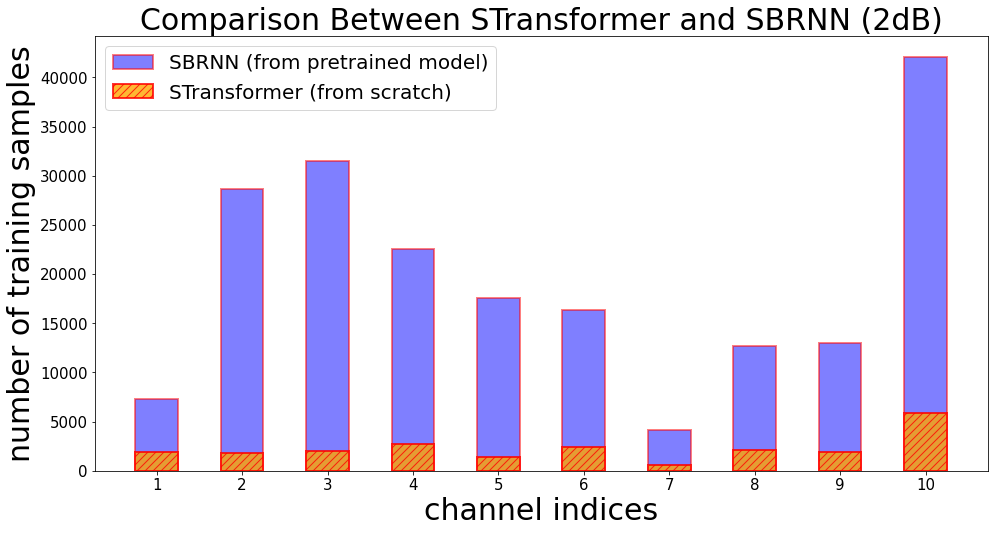

In [49]:
fig = plt.figure(figsize=(16, 8))
font = {
    'size': 30
}
ax = fig.add_subplot(111)
ax.bar(x = np.arange(1, 11),
       height = acc_LSTM, width = 0.5, edgecolor = 'red', color= 'blue', alpha = 0.5, align = 'center', linewidth = 2)
ax.bar(x = np.arange(1, 11),
       height = acc_STransformer, width = 0.5, edgecolor = 'red', color= 'orange', alpha = 0.8, align = 'center', linewidth = 2, hatch = '///')
ax.set_xticks(np.arange(1, 11))
ax.set_title('Comparison Between STransformer and SBRNN (2dB)', font)
ax.set_ylabel('number of training samples', font)
ax.set_xlabel('channel indices', font)
ax.tick_params(axis = 'both', labelsize = 15)
ax.legend(['SBRNN (from pretrained model)', 'STransformer (from scratch)'], fontsize = '20')
plt.savefig('../../paper writing/Training Samples Comparison.png', dpi=500)

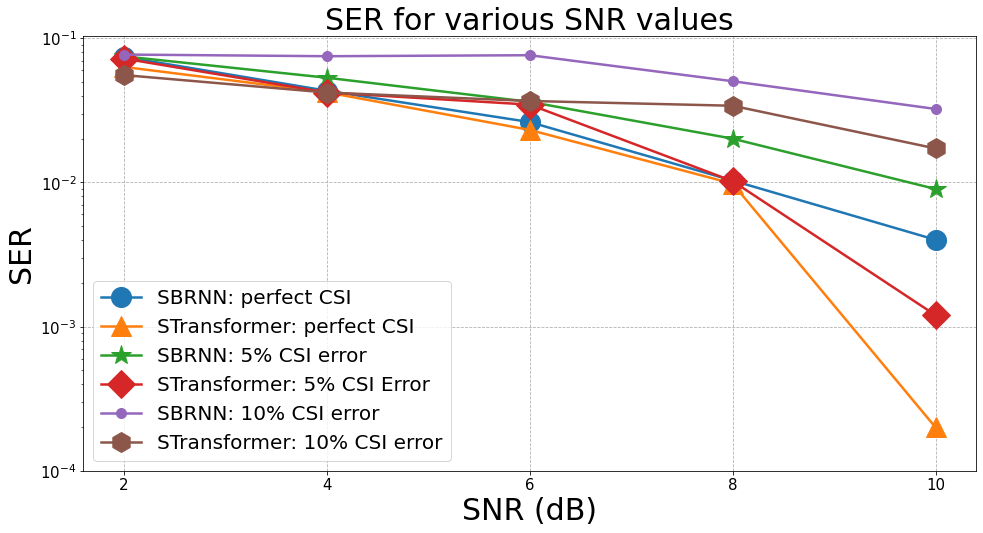

In [11]:
from matplotlib import pyplot as plt
import numpy as np
ser_lstm = [0.07421, 0.0432, 0.0262, 0.0103, 0.004]
ser_transformer = [0.06321, 0.04211, 0.02312, 0.0098, 0.0002]

ser_lstm_005error = [0.07481, 0.0532, 0.0362, 0.0201, 0.009]
ser_transformer_005error = [0.07221, 0.04201, 0.03462, 0.0102, 0.0012]

ser_lstm_010error = [0.077, 0.075, 0.0762, 0.0503, 0.0323]
ser_transformer_010error = [0.0555, 0.042, 0.0367, 0.034, 0.0172]
fig_1 = plt.figure(figsize = (16, 8))
ax = fig_1.add_subplot(111)
ax.semilogy(np.arange(2, 12, 2), ser_lstm, linewidth = 2.5, marker = 'o', markersize=20)
ax.semilogy(np.arange(2, 12, 2), ser_transformer, linewidth = 2.5, marker = '^', markersize = 20)
ax.semilogy(np.arange(2, 12, 2), ser_lstm_005error, linewidth = 2.5, marker = '*', markersize = 20)
ax.semilogy(np.arange(2, 12, 2), ser_transformer_005error, linewidth = 2.5, marker = 'D', markersize = 20)
ax.semilogy(np.arange(2, 12, 2), ser_lstm_010error, linewidth = 2.5, marker = '.', markersize = 20)
ax.semilogy(np.arange(2, 12, 2), ser_transformer_010error, linewidth = 2.5, marker = 'h', markersize = 20)
ax.legend(
    ['SBRNN: perfect CSI', 'STransformer: perfect CSI', 
     'SBRNN: 5% CSI error', 'STransformer: 5% CSI Error',
     'SBRNN: 10% CSI error', 'STransformer: 10% CSI error',
    ], 
    fontsize = 20
)
ax.set_xlabel('SNR (dB)', fontsize = 30)
ax.set_ylabel('SER', fontsize = 30)
ax.set_yticks([1e-1, 1e-2, 1e-3, 1e-4])
ax.set_xticks(np.arange(2, 12, 2))
ax.set_title('SER for various SNR values', fontsize = 30)
ax.tick_params(axis = 'both', which = 'both', labelsize = 15)
ax.grid(True, linestyle = '--')
plt.savefig('../../paper writing/SER_dB.png', dpi=500)


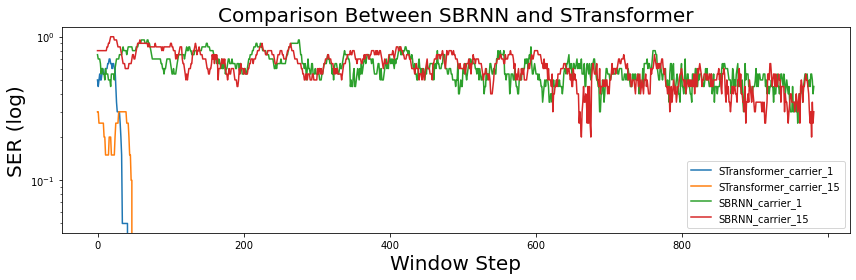

In [12]:
canvasl.draw_plot(
    [
        historyl['STransformer_carrier_1'],
        historyl['STransformer_carrier_15'],
        historyl['SBRNN_carrier_1'],
        historyl['SBRNN_carrier_15'],
        # historyl['Training_state_transformer'],
        # historyl['Training_state_lstm']
    ],
    xlabel = 'Window Step',
    ylabel = 'SER (log)',
    _title = 'Comparison Between SBRNN and STransformer',
    _semilogy = True
)
canvasl.save('../../paper writing/Picture 5.png', dpi = 500)

In [51]:

input_size = 2 # input size for each LSTM cell (complex numbers)
num_classes = 4 # number of classes for classification
window_size = 20
import random
import time
acc_total = list()
for idx in range (5):
    for epoch in range (1):
        # print (epoch)
        # print ('-----------------------------\n')
        acc_epoch = 0

        start = time.time()
        train_transformer_1 = True
        train_lstm_1 = True

        enc_transformer_1= Stransformers(d_obj, n_heads)
        enc_lstm_1 = BiLSTM(input_size, hidden_size, num_classes)
        _x = y_train[idx]
        _y= label_train[idx]
        _x = norm(_x)

        Loss = nn.CrossEntropyLoss()
        optimiser_transformer_0 = torch.optim.Adam(
            enc_transformer_1.parameters(),
            lr = 1e-3
        )
        optimiser_lstm_1 = torch.optim.Adam(
            enc_lstm_1.parameters(),
            lr = 1e-3,
        )
        
        cnt_print_transformer_1 = 0
        cnt_train = 0
        acc_train = 0
        acc_100 = []
        acc_100_lstm = []
        for cnt in range (0, symbol_num - window_size, 20):
            _cnt = cnt + window_size
            x = _x[cnt: cnt + window_size]
            y = _y[cnt: cnt + window_size]
            
            # carrier 0
            if train_transformer_1:
                Y_transformer = enc_transformer_1(x.permute(1, 0, 2))
                _, predicted = torch.max(Y_transformer, 1)
                acc_transformer_1 = (predicted == y).sum().item() / window_size
                acc_train += acc_transformer_1
                cnt_train += 1

                if acc_transformer_1 >= 0.95:
                    for param_group in optimiser_transformer_0.param_groups:
                        param_group['lr'] = 0.0001
                # decide whether the network requires training
                acc_100.append(acc_transformer_1)
                # print (acc_transformer_1)
                if len(acc_100) ==3: 
                    if all(number >= 0.99 for number in acc_100):
                        train_transformer_1 = False
                        print (f'STransformer: {_cnt}')
                    acc_100.pop(0)
        
                if train_transformer_1:
                    optimiser_transformer_0.zero_grad()
                    loss = Loss(Y_transformer, y)
                    loss.backward()
                    optimiser_transformer_0.step()

            Y_lstm = enc_lstm_1(x)
            _, predicted = torch.max(Y_lstm, 1)
            acc_lstm_1 = (predicted == y).sum().item() / window_size
            ser_SB_1 = 1 - acc_lstm_1

            acc_100_lstm.append(acc_lstm_1)
            if len(acc_100_lstm) ==3 and train_lstm_1 == True: 
                if all(number >= 0.99 for number in acc_100_lstm):
                    train_lstm_1 = False
                    print (f'SBRNN: {_cnt}')
                    # acc_LSTM.append(_cnt)
                    break
                acc_100_lstm.pop(0)
            if acc_lstm_1 >= 0.95:
                for param_group in optimiser_lstm_1.param_groups:
                    param_group['lr'] = 0.0001           

            if train_lstm_1:
                optimiser_lstm_1.zero_grad()
                loss_lstm_1 = Loss(Y_lstm, y)
                loss_lstm_1.backward()
                optimiser_lstm_1.step()

        acc_epoch = acc_train / cnt_train
    acc_test = 0
    acc_lstm_test = 0
    cnt_test = 0
    print (train_lstm_1)
    for cnt in range (symbol_num - window_size + 1):

        __x = y_test[idx] 
        __y= label_test[idx] 
        __x = norm(__x)
        x = __x[cnt: cnt + window_size] * random.uniform(0.9, 1.1)
        y = __y[cnt: cnt + window_size]

        # carrier 0
        Y_transformer = enc_transformer_1(x.permute(1, 0, 2))
        _, predicted = torch.max(Y_transformer, 1)
        acc_cnt_test = (predicted == y).sum().item() / window_size
        acc_test += acc_cnt_test

        Y_lstm = enc_lstm_1(x)
        _, predicted_lstm = torch.max(Y_lstm, 1)
        acc_cnt_test_lstm = (predicted_lstm == y).sum().item() / window_size
        acc_lstm_test += acc_cnt_test_lstm
        
        cnt_test += 1
        if cnt % 1000 == 0:
            print (f'------\n{cnt}\n-------')
            print (f' -- {acc_test / cnt_test} -- ')
    print (f'\n FINAL for {idx}\n')
    acc_total.append(acc_test / cnt_test)
    print (acc_test / cnt_test) 
    print (acc_lstm_test / cnt_test)

STransformer: 600
True
------
0
-------
 -- 0.9 -- 
------
1000
-------
 -- 0.9852147852147852 -- 
------
2000
-------
 -- 0.9852573713143495 -- 
------
3000
-------
 -- 0.9878207264245213 -- 
------
4000
-------
 -- 0.9877030742314319 -- 
------
5000
-------
 -- 0.9883523295340788 -- 
------
6000
-------
 -- 0.9876270621562856 -- 
------
7000
-------
 -- 0.9878445936294573 -- 
------
8000
-------
 -- 0.987520309961227 -- 
------
9000
-------
 -- 0.9878846794800404 -- 

 FINAL for 0

0.9880372708145418
0.9456066526399837
STransformer: 260
SBRNN: 4340
False
------
0
-------
 -- 1.0 -- 
------
1000
-------
 -- 0.9687812187812257 -- 
------
2000
-------
 -- 0.9733633183408419 -- 
------
3000
-------
 -- 0.9755248250583084 -- 
------
4000
-------
 -- 0.9752061984503733 -- 
------
5000
-------
 -- 0.9733553289341867 -- 
------
6000
-------
 -- 0.9731794700882835 -- 
------
7000
-------
 -- 0.9739180117125722 -- 
------
8000
-------
 -- 0.9727909011373111 -- 
------
9000
-------
 -- 0.972486

In [77]:
enc_transformer_hu= Stransformers(d_obj, 4)

enc_transformer_hu

Stransformers(
  (embedding): Linear(in_features=2, out_features=128, bias=True)
  (denoise): Linear(in_features=128, out_features=256, bias=True)
  (denoise2): Linear(in_features=256, out_features=128, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): RZTXEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): RZTXEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bi

In [81]:
txs = [4, 16, 64, 128, 256, 512]
tx_time = list()
tx_time_lstm = list()
for tx in txs:
    enc_transformer_1= Stransformers(d_obj, n_heads)
    enc_lstm_1 = BiLSTM(input_size, hidden_size, num_classes)
    xxx_transformer = torch.randn(tx, 20, 2)
    xxx_lstm = torch.randn(20, tx, 2)
    _s_trans = time.time()
    ex = enc_transformer_1(xxx_transformer)
    _e_trans = time.time()

    _s_lstm = time.time()
    ex_lstm = enc_lstm_1(xxx_lstm)
    _e_lstm = time.time()

    tx_time.append(_e_trans - _s_trans)
    print (_e_trans - _s_trans)
    tx_time_lstm.append(_e_lstm - _s_lstm)


0.1240079402923584
0.10000109672546387
0.37447023391723633
0.8167839050292969
1.6600382328033447
3.799309015274048


In [82]:
tx_time_lstm

[0.009604692459106445,
 0.009052038192749023,
 0.01595592498779297,
 0.024705886840820312,
 0.04863286018371582,
 0.09536576271057129]

([<matplotlib.axis.XTick at 0x7fa125361f70>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

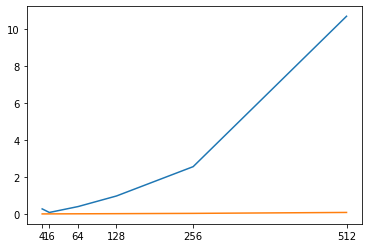

In [47]:
plt.plot(txs, tx_time)
plt.plot(txs, tx_time_lstm)

plt.xticks(txs)

0.36941896024464826


(array([687., 183.,  73.,  31.,  19.,   4.,   1.,   2.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ]),
 <BarContainer object of 8 artists>)

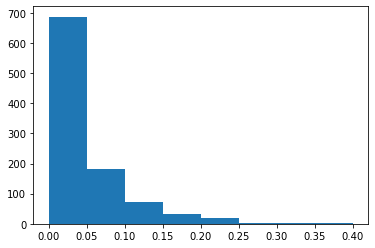

In [ ]:
from matplotlib import pyplot as plt
ser_2dB = [1-_s for _s in acc_total]
zero_num = ser_2dB.count(0)
print (max(ser_2dB))
mean_2dB = np.mean(ser_2dB)
plt.hist(ser_2dB, bins = np.arange(0, 0.45, 0.05))
# print (f'{zero_num}, {mean_2dB}')

800, 0.003257900101936515


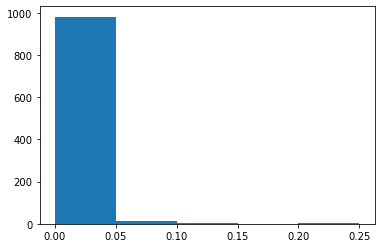

In [32]:
from matplotlib import pyplot as plt
ser_4dB = [1-_s for _s in acc_total]
zero_num = ser_4dB.count(0)
mean_4dB = np.mean(ser_4dB)
plt.hist(ser_4dB, bins = np.arange(0, 0.3, 0.05))
print (f'{zero_num}, {mean_4dB}')

In [43]:
y_4dB

array([982.,  11.,   3.,   0.,   3.])

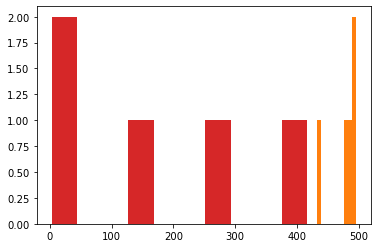

In [16]:
sym_Strans = [432, 480, 487, 495, 496]
sym_SBRNN = [3, 32, 130, 291, 417]
y_Strans = plt.hist(sym_Strans)[0]
x_Strans = plt.hist(sym_Strans)[1]
y_SBRNN = plt.hist(sym_SBRNN)[0]
x_SBRNN = plt.hist(sym_SBRNN)[1]

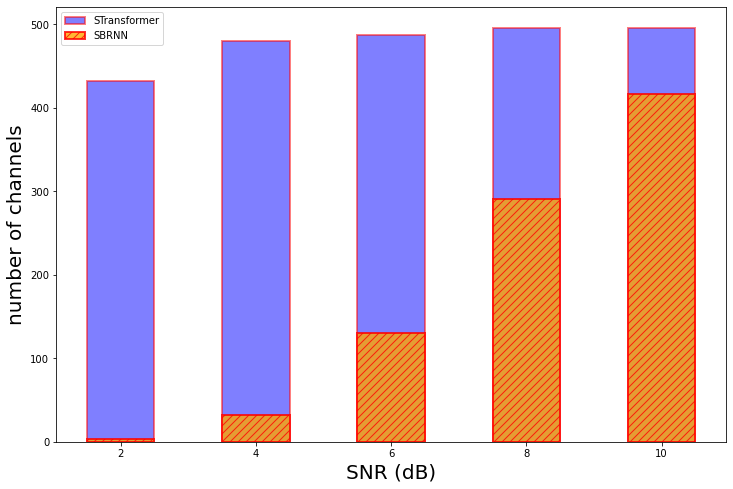

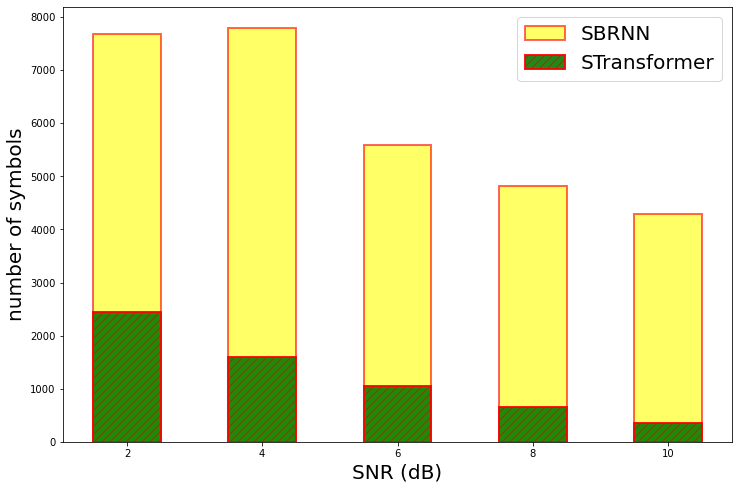

In [63]:
sym_Strans = [432, 480, 487, 495, 496]
sym_SBRNN = [3, 32, 130, 291, 417]

fig = plt.figure(figsize=(12, 8))
font = {
    'size': 20
}
ax = fig.add_subplot(111)
ax.bar(x = np.arange(2, 12, 2),
       height = sym_Strans, width = 1, edgecolor = 'red', color= 'blue', alpha = 0.5, align = 'center', linewidth = 2)
ax.bar(x = np.arange(2, 12, 2),
       height = sym_SBRNN, width = 1, edgecolor = 'red', color= 'orange', alpha = 0.8, align = 'center', linewidth = 2, hatch = '///')
ax.legend(['STransformer', 'SBRNN'])
ax.set_ylabel('number of channels', font)
ax.set_xlabel('SNR (dB)', font)
plt.savefig('../../Dissertation/Figure/SuccessfulTraining_SNR.png', dpi = 300)


sym_Strans = [2441, 1600, 1044, 660, 348]
sym_SBRNN = [7673, 7800, 5589, 4819, 4286]

fig2 = plt.figure(figsize=(12, 8))
font = {
    'size': 20
}
# plt.savefig('./results/SER_1000.png', dpi=500)
ax2 = fig2.add_subplot(111)
ax2.bar(x = np.arange(2, 12, 2),
       height = sym_SBRNN, width = 1, edgecolor = 'red', color= 'yellow', alpha = 0.6, align = 'center', linewidth = 2)
ax2.bar(x = np.arange(2, 12, 2),
       height = sym_Strans, width = 1, edgecolor = 'red', color= 'green', alpha = 0.9, align = 'center', linewidth = 2, hatch = '///')

ax2.legend(['SBRNN', 'STransformer'], fontsize = 20)
ax2.set_ylabel('number of symbols', font)
ax2.set_xlabel('SNR (dB)', font)
plt.savefig('../../Dissertation/Figure/TrainingSamples_SNR.png', dpi = 300)


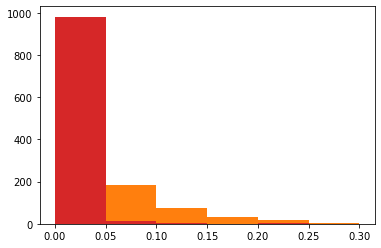

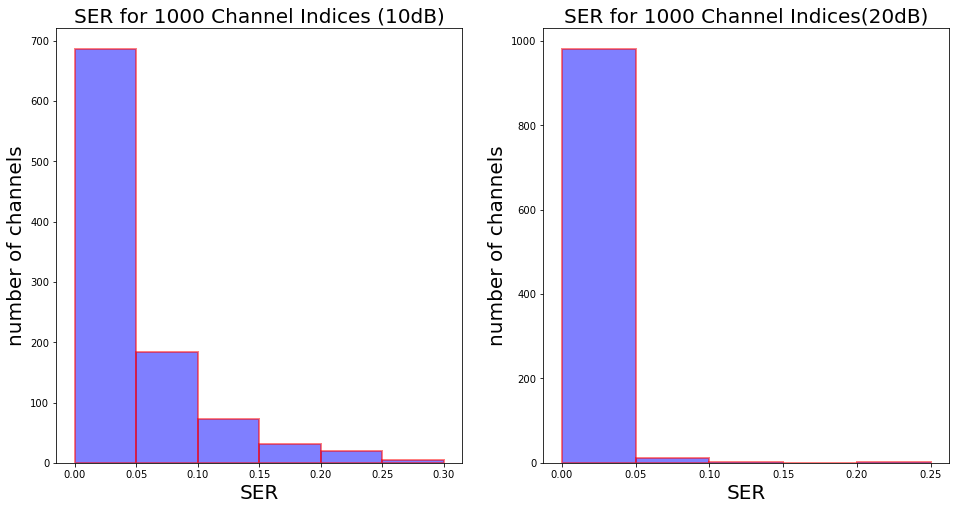

In [42]:

y_2dB = plt.hist(ser_2dB, bins = np.arange(0, 0.35, 0.05))[0]
x_2dB = plt.hist(ser_2dB, bins = np.arange(0, 0.35, 0.05))[1]
X_4dB = plt.hist(ser_4dB, bins = np.arange(0, 0.3, 0.05))[0]
x_4dB = plt.hist(ser_4dB, bins = np.arange(0, 0.3, 0.05))[1]
fig = plt.figure(figsize=(16, 8))
font = {
    'size': 20
}
ax = fig.add_subplot(121)
x_2dB_axis = [(x_2dB[i] + x_2dB[i+1])/2 - 0.025 for i in range (len(y_2dB))]
x_4dB_axis = [(x_4dB[i] + x_4dB[i+1])/2 - 0.025 for i in range (len(y_4dB))]
ax.bar(x = x_2dB_axis,
       height = y_2dB, width = 0.05, edgecolor = 'red', color= 'blue', alpha = 0.5, align = 'edge', linewidth = 2)


ax.set_title('SER for 1000 Channel Indices (10dB)', font)
ax.set_ylabel('number of channels', font)
ax.set_xlabel('SER', font)
# plt.savefig('./results/SER_1000.png', dpi=500)
ax2 = fig.add_subplot(122)
ax2.bar(x = x_4dB_axis,
       height = y_4dB, width = 0.05, edgecolor = 'red', color= 'blue', alpha = 0.5, align = 'edge', linewidth = 2)


ax2.set_title('SER for 1000 Channel Indices(20dB)', font)
ax2.set_ylabel('number of channels', font)
ax2.set_xlabel('SER', font)
plt.show()

# plt.savefig('./results/SER_1000.png', dpi = 500)

In [49]:
X_noisy = torch.tensor(y_simo_isac, dtype = torch.float32).permute(1, 4, 0, 2, 3).contiguous().view(-1, 2, 16, 10000)
# Generate some noise
X = torch.tensor(y_simo_isac_org, dtype = torch.float32).permute(1, 4, 0, 2, 3).contiguous().view(-1, 2, 16, 10000)
print (X.shape)
print (X_noisy.shape)

RuntimeError: shape '[-1, 2, 16, 10000]' is invalid for input of size 128000

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Denoising CNN for complex MIMO-OFDM signals
class DenoisingCNN(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(DenoisingCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, output_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Initialize model, criterion, and optimizer
input_channels = 2  # Real and imaginary parts
output_channels = 2
model = DenoisingCNN(input_channels, output_channels)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Generate some random data for training
num_samples = 5
num_subcarriers = 16
num_symbols = 10000

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_noisy)
    loss = criterion(outputs, X)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Finished Training')


Epoch [1/100], Loss: 0.5007
Epoch [2/100], Loss: 0.4594


KeyboardInterrupt: 

In [ ]:
X_test = torch.randn(5, input_channels, num_subcarriers, num_symbols, 4)
X_test_noisy = X_test + 1 * torch.randn(5, input_channels, num_subcarriers, num_symbols, 4)
print (X_noisy.shape)
print (X_test_noisy.shape)
# Reshape the input to match the model's input dimensions
X_test_noisy = X_noisy.view(-1, input_channels, num_subcarriers, num_symbols)
X_test_noisy.shape

torch.Size([5, 2, 16, 10000, 4])
torch.Size([5, 2, 16, 10000, 4])


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [ ]:
_channel_gen = channel_gen()
Y_CE = torch.tensor(
    np.array(_y_n)[0, 0, 0],
    dtype = torch.cfloat
)
optimiser = torch.optim.Adam(
    _channel_gen.parameters(),
    lr = 1e-5,
    weight_decay=1e-6
)
h_0 = h_org[0, 0, 0]
_channel_test = 0.01 * torch.randn(1, 4, 2)
for epoch in range(2000):
    _h = _channel_gen(_channel_test).squeeze() + 0.1 * torch.randn(_h.shape)
    H = torch.view_as_complex(_h).reshape(4, 1)
    x = torch.tensor([-0.707 + 0.707j], dtype = torch.cfloat).reshape(1, 1)
    Y = torch.mm(H, x) 
    optimiser.zero_grad()
    loss = complex_mse_loss(Y, Y_CE)
    loss.backward()
    optimiser.step()
    if torch.abs(torch.real(loss)) < 0.1 and torch.abs(torch.imag(loss) )< 0.1:
        print (loss)
        print (H)
        print (h_0)
        break



In [66]:
acc_list = [_a if _a < 40 else 10 for _a in acc_list]

(array([584., 389.,  11.,   6.,   2.,   0.,   0.,   1.,   0.,   1.]),
 array([ 0.16181684,  1.16522124,  2.16862564,  3.17203004,  4.17543445,
         5.17883885,  6.18224325,  7.18564765,  8.18905206,  9.19245646,
        10.19586086]),
 <BarContainer object of 10 artists>)

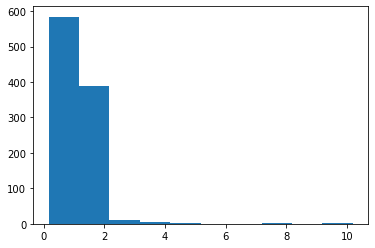

In [67]:
plt.hist(training_time)

[ 0 10 20 30 40]


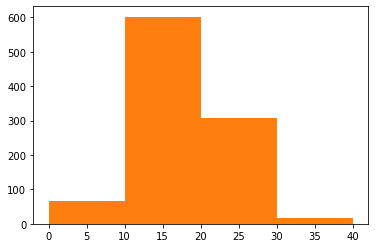

In [93]:
bin = np.arange(0, 50, 10) 
_y_acc = plt.hist(acc_list, bins=bin)[0]
_x_acc = plt.hist(acc_list, bins=bin)[1]
print (_x_acc)

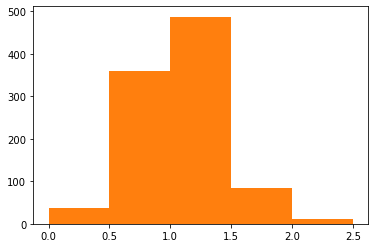

In [94]:
bin1 = np.arange(0, 3, 0.5) 
number_training_time = plt.hist(training_time, bins = bin1)[0]
time_training = plt.hist(training_time, bins = bin1)[1]

In [95]:
x_axis_training = [(time_training[i] + time_training[i+1])/2 for i in range (len(number_training_time))]
x_axis_step = [(_x_acc[i] + _x_acc[i+1])/2 for i in range (len(_y_acc))]

In [140]:

_x_axis_step

[25.0, 35.0, 45.0, 55.0]

In [103]:
_x_axis_step = [_x+20 for _x in x_axis_step]

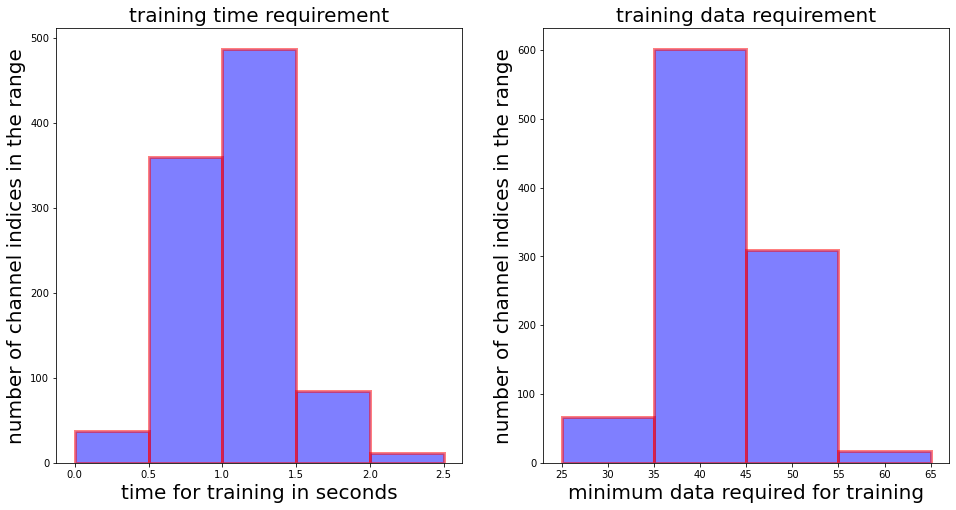

In [141]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
font = {
    'size': 20
}
ax1 = fig.add_subplot(121)
ax1.bar(
    x = x_axis_training,
    width=0.5, height = number_training_time,
    alpha = 0.5,
    color = 'blue',
    edgecolor = 'red',
    linewidth = 3
)
ax1.set_title('training time requirement', fontdict=font)
ax1.set_xlabel('time for training in seconds', fontdict=font)
ax1.set_ylabel('number of channel indices in the range', fontdict = font)

ax2 = fig.add_subplot(122)
ax2.bar(
    x = _x_axis_step,
    width = 10, height = _y_acc,
    alpha = 0.5,
    align='edge',
    color = 'blue',
    edgecolor = 'red',
    linewidth = 3
)
ax2.set_title('training data requirement', fontdict=font)
ax2.set_xlabel('minimum data required for training',fontdict=font)
ax2.set_ylabel('number of channel indices in the range', fontdict = font)

plt.savefig ('./results/STransformers_2dB.png', dpi = 400)
plt.show()

0
[0.         0.06505805 0.1301161  0.19517415 0.26023221 0.32529026
 0.39034831 0.45540636 0.52046441 0.58552246 0.65058051]


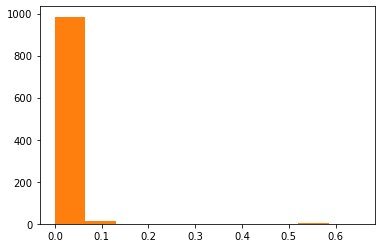

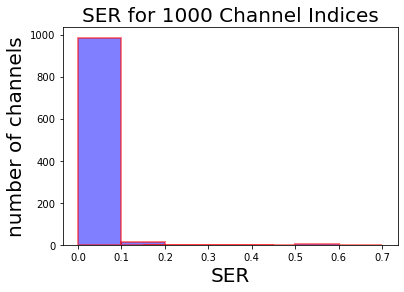